In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn as nn
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import seaborn as sns



/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): symbol not found in flat namespace '__ZN5torch8autograd13_wrap_outputsERKNSt3__16vectorIN2at6TensorENS1_9allocatorIS4_EEEERKNS1_13unordered_setIPN3c1010TensorImplENS1_4hashISD_EENS1_8equal_toISD_EENS5_ISD_EEEESL_NSB_8ArrayRefINSB_8optionalIS4_EEEERKNS1_10shared_ptrINS0_4NodeEEENS1_8functionIFS7_S7_S7_EEE'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/torch_sparse/_diag_cpu.so, 0x0006): symbol not found in flat namespace

# Underlying SCM

In [2]:
# links_coeffs = {
#     0: [((0, -1), 0.7, lin_f), ((1, -1), -0.8, lin_f)],
#     1: [((1, -1), 0.8, lin_f), ((3, -1), 0.8, lin_f)],
#     2: [((2, -1), 0.5, lin_f), ((1, -2), 0.5, lin_f), ((3, -3), 0.6, lin_f)],
#     3: [((3, -1), 0.4, lin_f)]
# }

# Loading data

In [3]:
df = pd.read_pickle('tig_df.pkl')

# GNN

In [4]:

class TimeSeriesGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TimeSeriesGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Only predict for x0
        x0_pred = self.linear(x[0].unsqueeze(0))
        
        return x0_pred


def prepare_data(df, num_timesteps=None, max_lag=3):
    if num_timesteps is None or num_timesteps > len(df):
        num_timesteps = len(df)

    graphs = []
    for t in range(max_lag, num_timesteps - 1):
        try:
            # Create a list to hold features for each variable
            features = []
            
            # x0 features: current value and first lag of x1
            features.append([df.loc[t, 'x0'], df.loc[t-1, 'x1']])
            
            # x1 features: current value and first lag of x3
            features.append([df.loc[t, 'x1'], df.loc[t-1, 'x3']])
            
            # x2 features: current value, second lag of x1, and third lag of x3
            features.append([df.loc[t, 'x2'], df.loc[t-2, 'x1'], df.loc[t-3, 'x3']])
            
            # x3 features: just the current value
            features.append([df.loc[t, 'x3']])
            
            # Convert to tensor, padding shorter sequences with zeros
            max_features = max(len(f) for f in features)
            x = torch.tensor([f + [0] * (max_features - len(f)) for f in features], dtype=torch.float)
            
            edge_index = torch.tensor([
                [1, 2, 3, 1],  # Source nodes
                [0, 1, 2, 2]   # Target nodes
            ], dtype=torch.long)
            
            y = torch.tensor([df.loc[t+1, 'x0']], dtype=torch.float)
            
            graphs.append(Data(x=x, edge_index=edge_index, y=y))
            
            # Debugging: print the shape of x for the first few graphs
            if len(graphs) <= 5:
                print(f"Graph {len(graphs)}: x shape = {x.shape}")
            
        except KeyError as e:
            print(f"KeyError at timestep {t}: {e}")
            print("Skipping this timestep.")
            continue
        except Exception as e:
            print(f"Unexpected error at timestep {t}: {e}")
            print("DataFrame at this timestep:")
            print(df.loc[t-max_lag:t+1])
            raise
    
    return graphs


graphs = prepare_data(df)

# Split data into train and test sets
train_graphs = graphs[:-100]
test_graphs = graphs[-100:]

# Initialize the model
model = TimeSeriesGNN(input_dim=3, hidden_dim=64, output_dim=1)

# Training loop (simplified)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(100):
    losses_ = []
    for graph in train_graphs:
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out, graph.y)
        loss.backward()
        optimizer.step()
        losses_.append(loss.detach())
    print(f'epoch {epoch} __ loss {np.mean(losses_)}')

# Evaluation
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for graph in test_graphs:
        pred = model(graph)
        predictions.append(pred.item())
        true_values.append(graph.y.item())



Graph 1: x shape = torch.Size([4, 3])
Graph 2: x shape = torch.Size([4, 3])
Graph 3: x shape = torch.Size([4, 3])
Graph 4: x shape = torch.Size([4, 3])
Graph 5: x shape = torch.Size([4, 3])


/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 __ loss 10.740341186523438
epoch 1 __ loss 6.8679351806640625
epoch 2 __ loss 6.05914306640625
epoch 3 __ loss 6.459819316864014
epoch 4 __ loss 5.8181023597717285
epoch 5 __ loss 5.9531474113464355
epoch 6 __ loss 5.839842796325684
epoch 7 __ loss 5.978331089019775
epoch 8 __ loss 5.777619361877441
epoch 9 __ loss 5.656830787658691
epoch 10 __ loss 5.935980796813965
epoch 11 __ loss 5.767146587371826
epoch 12 __ loss 5.633432865142822
epoch 13 __ loss 5.4000678062438965
epoch 14 __ loss 5.624144554138184
epoch 15 __ loss 5.703952312469482
epoch 16 __ loss 5.473876953125
epoch 17 __ loss 5.088603496551514
epoch 18 __ loss 5.107306480407715
epoch 19 __ loss 5.774684429168701
epoch 20 __ loss 5.253459453582764
epoch 21 __ loss 5.460048198699951
epoch 22 __ loss 5.1751837730407715
epoch 23 __ loss 5.429209232330322
epoch 24 __ loss 5.05360746383667
epoch 25 __ loss 4.887927532196045
epoch 26 __ loss 4.75736665725708
epoch 27 __ loss 5.64394998550415
epoch 28 __ loss 5.592091083526

In [9]:
graphs[0]["x"]

tensor([[-8.7986,  1.8747,  0.0000],
        [ 0.3562,  0.5553,  0.0000],
        [ 0.6186,  2.5756,  0.9187],
        [-0.8240,  0.0000,  0.0000]])

In [10]:
df.head(6)

,x0,x1,x2,x3
0,-7.141185,2.030301,2.012427,0.918713
1,-9.000128,2.575605,2.596406,0.308284
2,-9.783191,1.874707,2.936852,0.555286
3,-8.798581,0.356159,0.618557,-0.824033
4,-8.204947,-0.714147,1.278075,1.385024
5,-3.307124,-0.608191,1.782078,-0.399524


# Accuracy metrics

In [5]:
import numpy as np

def calculate_smape(true_values, predictions):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    
    :param true_values: List or array of actual values
    :param predictions: List or array of predicted values
    :return: SMAPE value
    """
    true_values = np.array(true_values)
    predictions = np.array(predictions)
    
    # Avoid division by zero
    denominator = np.abs(true_values) + np.abs(predictions)
    
    # If both true and predicted are zero, consider it as a perfect prediction
    zero_indices = denominator == 0
    denominator[zero_indices] = 1  # Temporarily set to 1 to avoid division by zero
    
    smape = np.mean(2 * np.abs(predictions - true_values) / denominator)
    
    # Adjust for cases where both true and predicted were zero
    smape = smape * (1 - zero_indices.mean())
    
    return smape * 100  # Convert to percentage

# Usage:
smape = calculate_smape(true_values, predictions)
print(f"SMAPE: {smape:.2f}%")

SMAPE: 73.14%


In [6]:
import numpy as np

def calculate_smape(true_values, predictions):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    
    :param true_values: List or array of actual values
    :param predictions: List or array of predicted values
    :return: SMAPE value
    """
    true_values = np.array(true_values)
    predictions = np.array(predictions)
    
    # Avoid division by zero
    denominator = np.abs(true_values) + np.abs(predictions)
    
    # If both true and predicted are zero, consider it as a perfect prediction
    zero_indices = denominator == 0
    denominator[zero_indices] = 1  # Temporarily set to 1 to avoid division by zero
    
    smape = np.mean(2 * np.abs(predictions - true_values) / denominator)
    
    # Adjust for cases where both true and predicted were zero
    smape = smape * (1 - zero_indices.mean())
    
    return smape * 100  # Convert to percentage

# Usage:
smape = calculate_smape(true_values, predictions)
print(f"SMAPE: {smape:.2f}%")

SMAPE: 73.14%


# Plotting

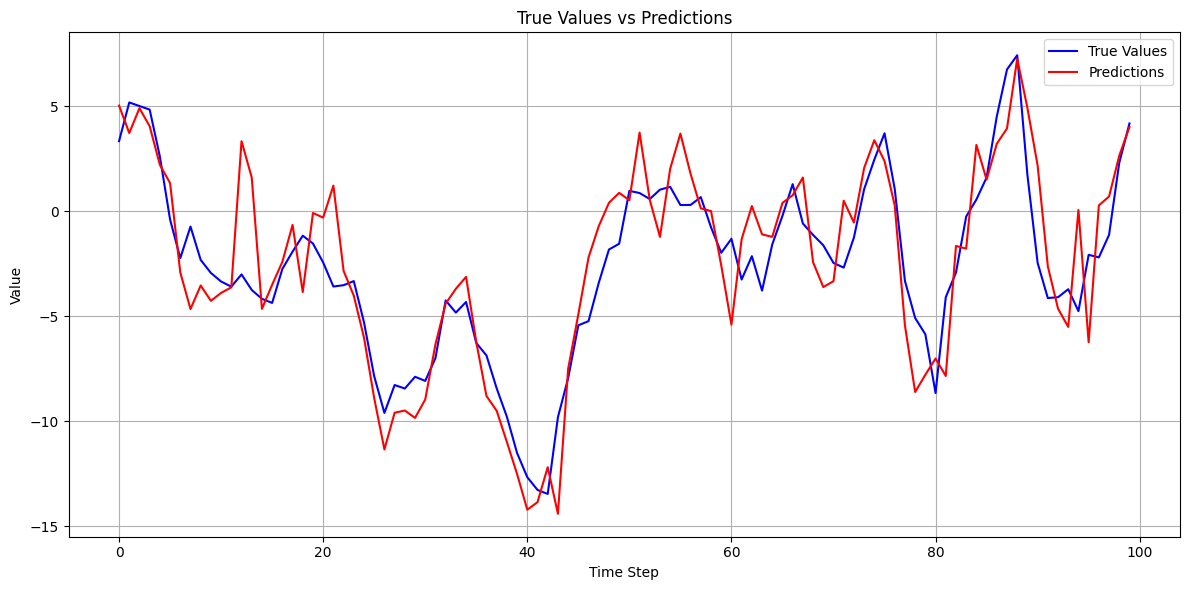

In [7]:

def plot_true_vs_predicted(true_values, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values', color='blue')
    plt.plot(predictions, label='Predictions', color='red')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('True Values vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_true_vs_predicted(true_values, predictions)

/var/folders/tt/3h_jlt8571z664b95jr80v_40000gn/T/ipykernel_31874/199101958.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_melted, x='Value', hue='Type', shade=True, alpha=0.5)
/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


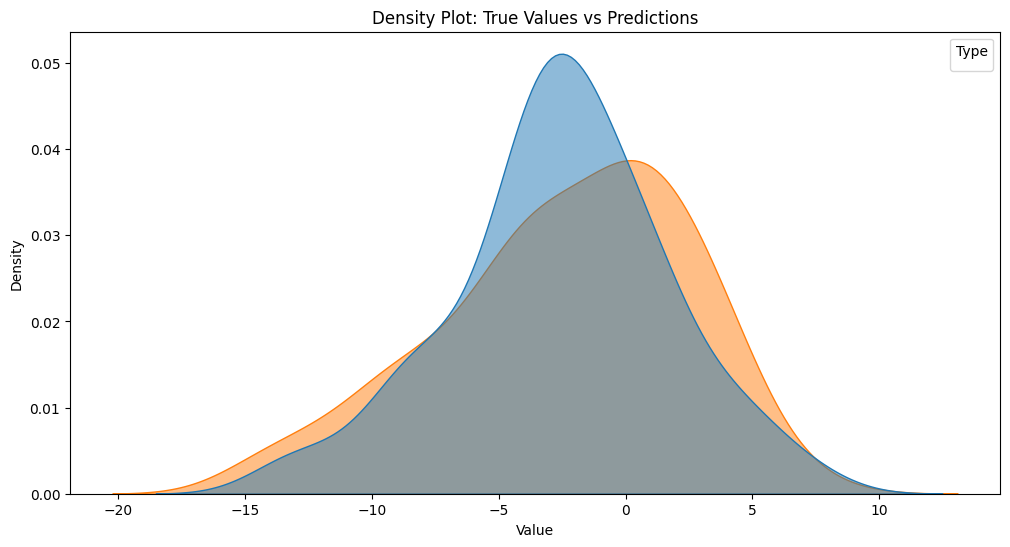

In [8]:
def plot_density(true_values, predictions):
    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'True Values': true_values,
        'Predictions': predictions
    })

    # Melt the DataFrame to long format
    df_melted = df.melt(var_name='Type', value_name='Value')

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=df_melted, x='Value', hue='Type', shade=True, alpha=0.5)
    
    plt.title('Density Plot: True Values vs Predictions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Add a legend
    plt.legend(title='Type')
    
    # Show the plot
    plt.show()

# Assuming you have your true_values and predictions lists
plot_density(true_values, predictions)